In [1]:
clean_up=True # removes gams-related files in work-folder if true
%run StdPackages.ipynb
os.chdir(directory['py'])
os.chdir(directory['curr'])
# from mpl_toolkits.axisartist.axislines import AxesZero
from matplotlib.ticker import NullFormatter
from cycler import cycler
import warnings
#%run A1_ID_Calib_jonathan2.ipynb
colors = "#1f77b4 #ff770e #2ca02c #d62728".split()
plt.rcParams.update({"axes.prop_cycle":cycler(color=colors)})

The file_gams_py_gdb0.gdx is still active and was not deleted.
The file_gams_py_gdb1.gdx is still active and was not deleted.
The file_gams_py_gdb2.gdx is still active and was not deleted.


## A rising price of emissions
We present graphically what happens when the emission price gradually increases (static model solution for each price).

In [2]:
#START HER MED NYE FIGURER FRA PICKLES.
x_var = "pM"
catalog = "categoryexperiment_ID"
with (open(x_var + "_" + catalog + ".pkl", "rb")) as f:
    df = pickle.load(f)    

In [3]:
#Calculate abated emissions
if catalog in ["main_catalog", "categoryexperiment_EOP"]:
    df["M0-M"] = df["M0"].iloc[0] - df["M"]
elif catalog in ["categoryexperiment_ID"]:
    df["M0-M"] = df["M0"].iloc[0] - df["M0"]

In [4]:
def translate(col):    
    translate = {
        "M0":"Emissions",
        "pM":"Price of emissions",
        "PwThat_basetech_EH_oil":"Effective oil price",
        "PwThat_basetech_EH_oil_linear":"Oil price without end-of-pipe",
        "qD_basetech_EH_oil":"Oil use",
        "qD_basetech_EH_electricity":"Electricity use",
        "qD_U0_ID_C_EH_2":"Baseline technology",
        "qD_U_ID_t2_1":"Clean technology",
        "qD_U_ID_t1_2":"Semi-clean technology",
        "qD_EH":"Energy service",
        "qD_Y":"Y composite",
        "M0_CO2":"CO2 Emissions",
        "M0-M":"Abated emissions",
        "PwThat_U_ID_t1_2":"Semi-clean technology", 
        "PwThat_U0_ID_C_EH_2":"Baseline technology", 
        "PwThat_U_ID_t2_1":"Clean technology", 
        "PwThat_C_EH_2":"Component with overlap",
        "qD_C_EH_2":"Component with overlap",
        "qD_oil":"Total oil use",
        "qD_U_ID_t1_1":"Input-displacing technology"
    }
    if col in translate:
        return translate[col]
    else:
        return col

def format_double_axes(ax, ax2, x_label="", y_label="", hide_ticks=False):
    ax.set_xlabel(x_label, fontsize=20)
    ax.set_ylabel(y_label, fontsize=20, rotation=0)
    ax.yaxis.set_label_coords(0.1,1.02)
    if hide_ticks:
        ax.get_xaxis().set_ticks([])
        ax2.get_yaxis().set_ticks([])
    # ax.get_yaxis().set_ticks([])
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_linewidth(0.5)
    ax.spines["left"].set_edgecolor("k")
    ax.spines["bottom"].set_edgecolor("k")
    ax.spines["bottom"].set_linewidth(0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax2.grid(False)
    #ax.set_axisbelow(True)
    ax.grid(axis='y', color="lightgrey", linewidth=0.2)
    ax.get_yaxis().set_major_formatter(NullFormatter())

def format_single_axis(axes, x_label="", y_label="", hide_ticks=False):
    axes.set_xlabel(x_label, fontsize=20)
    axes.set_ylabel(y_label, fontsize=20, rotation=0)
    axes.yaxis.set_label_coords(0.1,1.02)
    if hide_ticks:
        axes.get_xaxis().set_ticks([])
#     axes.get_yaxis().set_ticks([])
    axes.spines["left"].set_visible(True)
    axes.spines["bottom"].set_visible(True)
    axes.spines["left"].set_linewidth(0.5)
    axes.spines["left"].set_edgecolor("k")
    axes.spines["bottom"].set_edgecolor("k")
    axes.spines["bottom"].set_linewidth(0.5)
    axes.spines["right"].set_visible(False)
    axes.spines["top"].set_visible(False)
    #axes.set_axisbelow(True)
    axes.grid(axis='y', color="lightgrey", linewidth=0.2)
    axes.get_yaxis().set_major_formatter(NullFormatter())
    

In [5]:
if catalog == "main_catalog":
    vlines = df[["PwThat_EOP_t1", "PwThat_EOP_t2"]].mean().to_list()
elif catalog == "categoryexperiment_EOP":
    vlines = df[["PwThat_U_EOP_t1_1"]].mean().to_list()
elif catalog == "categoryexperiment_ID":
    vlines = df[["PwThat_U_ID_t1_1"]].mean().to_list()

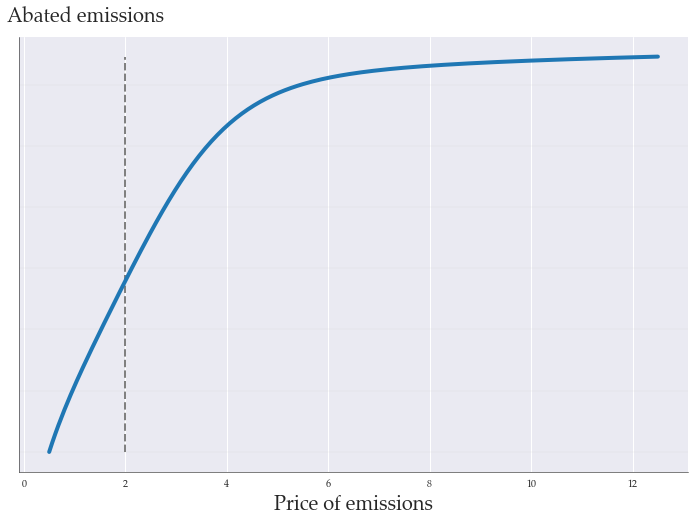

In [6]:
#Emission figure
fig = plt.figure(figsize=(12, 8))
fig.add_subplot(1, 1, 1)
ax = fig.get_axes()[0]
col = "M0-M"
with warnings.catch_warnings():
    warnings.simplefilter("ignore") #Otherwise throws warning if the column is named "M"
    #ax.plot(df.index, col, color=colors[0], data=df, label=translate(col), linewidth=4)
    ax.plot(df.index, df["M0-M"], color=colors[0], label=translate(col), linewidth=4)
ax.vlines(x=vlines, ymin=df[col].min(), ymax=df[col].max(), ls='--', color="grey", lw=2)
format_single_axis(ax, x_label=translate(df.index.name), y_label=translate(col))
fig.savefig("AbatedEmissions_" + catalog + ".pdf", bbox_inches="tight", transparent=True, facecolor="none", edgecolor='none')

In [7]:
del fig, ax

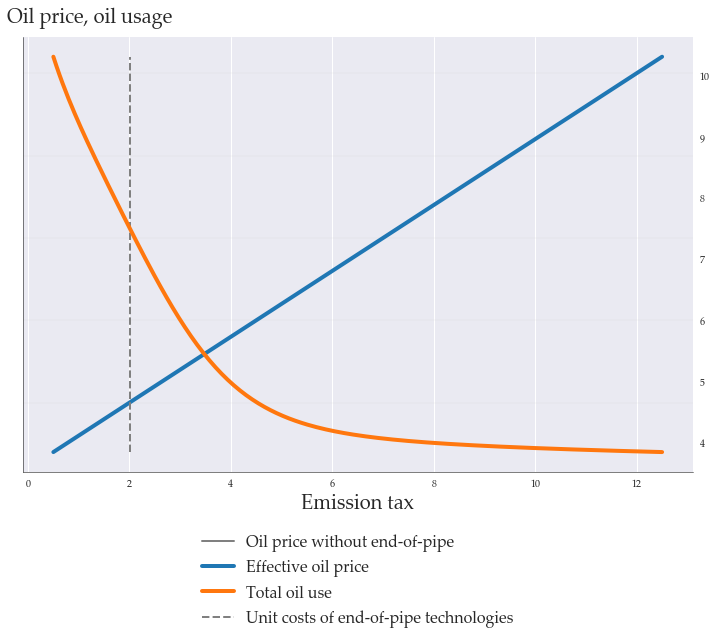

In [8]:
col = "PwThat_basetech_EH_oil"
slope = df[col].iloc[0:2].reset_index().diff().iloc[1, 1] / df[col].iloc[0:2].reset_index().diff().iloc[1, 0]
df[col + "_linear"] = pd.Series(((pd.Series(df[col].index) - df.index[0]) * (df[col].iloc[0:2].reset_index().diff().iloc[1, 1] / df[col].iloc[0:2].reset_index().diff().iloc[1, 0]) + df[col].iloc[0]).values, index=df.index)
#Figure with oil price and oil usage
fig = plt.figure(figsize=(12, 8))
fig.add_subplot(1, 1, 1)
ax = fig.get_axes()[0]
col = "PwThat_basetech_EH_oil"
assert col in df.columns
df[col + "_linear"] = pd.Series(((pd.Series(df[col].index) - df.index[0]) * (df[col].iloc[0:2].reset_index().diff().iloc[1, 1] / df[col].iloc[0:2].reset_index().diff().iloc[1, 0]) + df[col].iloc[0]).values, index=df.index)
ax.plot(df.index, col + "_linear", data=df, label=translate(col + "_linear"), linewidth=2, color="grey")
ax.plot(df.index, col, data=df, label=translate(col), linewidth=4, color=colors[0])
ax2 = ax.twinx()
col = "qD_oil"
ax2.plot(df.index, col, data=df, label=translate(col), linewidth=4, color=colors[1])
ax2.vlines(x=vlines, ymin=df[col].min(), ymax=df[col].max(), ls='--', color="grey", lw=2, label="Unit costs of end-of-pipe technologies")
lines, labels = ax.get_legend_handles_labels()
lines = lines + ax2.get_legend_handles_labels()[0]
labels = labels + ax2.get_legend_handles_labels()[1]
ax.legend(lines, labels, fontsize=16, loc="center", bbox_to_anchor=(0.5, -0.25))
format_double_axes(ax, ax2, "Emission tax", "Oil price, oil usage")
fig.savefig("oil_price_and_use_" + catalog + ".pdf", bbox_inches="tight", transparent=True, facecolor="none", edgecolor='none')
del fig, ax, ax2


Figure showing quantities in the MNL nest where the technology and the baseline compete

In [9]:
if catalog == "main_catalog":
    fig = plt.figure(figsize=(12, 8))
    fig.add_subplot(1, 1, 1)
    ax = fig.get_axes()[0]

    for i, col in enumerate(["qD_U0_ID_C_EH_2", "qD_U_ID_t1_2", "qD_U_ID_t2_1", "qD_C_EH_2"]):
        assert col in df.columns
        ax.plot(df.index, col, data=df, label=translate(col), linewidth=4, color=colors[i])
    # col = 
    # assert col in df.columns
    # ax.plot(df.index, col, data=df, label=translate(col), linewidth=4, color=colors[1])
    # ax2 = ax.twinx()

    ax.vlines(x=vlines, ymin=0, ymax=ax.get_ylim()[1]*0.95, ls='--', color="grey", lw=2, label="Unit costs of end-of-pipe technologies")
    lines, labels = ax.get_legend_handles_labels()
    # lines = lines + ax2.get_legend_handles_labels()[0]
    # labels = labels + ax2.get_legend_handles_labels()[1]
    ax.legend(lines, labels, fontsize=16, loc="center", bbox_to_anchor=(0.5, -0.25))
    format_single_axis(ax, "Emission tax", "Technology goods overlap")
    fig.savefig("Technology_goods_overlap_" + catalog + ".pdf", bbox_inches="tight", transparent=True, facecolor="none", edgecolor='none')
    del fig, ax

In [10]:
if catalog == "main_catalog":
    fig = plt.figure(figsize=(12, 8))
    fig.add_subplot(1, 1, 1)
    ax = fig.get_axes()[0]

    for i, col in enumerate(["PwThat_U_ID_t1_2", "PwThat_U0_ID_C_EH_2", "PwThat_U_ID_t2_1", "PwThat_C_EH_2"]):
        assert col in df.columns
        ax.plot(df.index, col, data=df, label=translate(col), linewidth=4, color=colors[i])
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, fontsize=16, loc="center left")


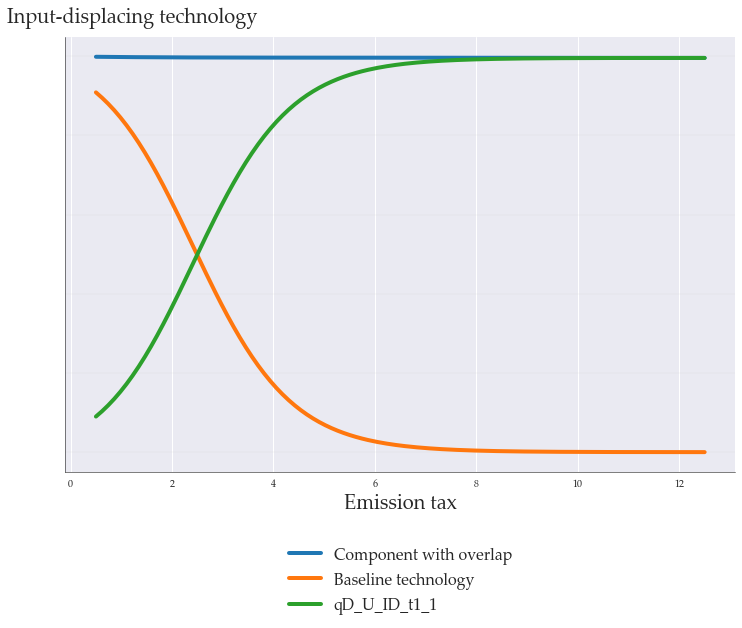

In [15]:
if "categoryexperiment" in catalog:
    fig = plt.figure(figsize=(12, 8))
    fig.add_subplot(1, 1, 1)
    ax = fig.get_axes()[0]
    if "ID" in catalog:
        cols = ["qD_C_EH_2", "qD_U0_ID_C_EH_2", "qD_U_ID_t1_1"]
    elif "EOP" in catalog:
        cols = "YO"
    for i, col in enumerate(cols):
        assert col in df.columns
        ax.plot(df.index, col, data=df, label=translate(col), linewidth=4, color=colors[i])
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, fontsize=16, loc="center", bbox_to_anchor=(0.5, -0.25))
    format_single_axis(ax, "Emission tax", "Input-displacing technology")

In [12]:
df[1.5:3]

,M0,PbT,PwThat_U_ID_t1_1,PwThat_basetech_EH_oil,PwThat_U0_ID_C_EH_2,PwThat_C_EH_2,PwThat_basetech_EH,qD_U_ID_t1_1,qD_oil,qD_basetech_EH_oil,qD_U0_ID_C_EH_2,qD_C_EH_2,qD_basetech_EH,M0-M,PwThat_basetech_EH_oil_linear
pM,,,,,,,,,,,,,,,
1.525126,16.607858,1.343789,2.001388,4.050251,1.642878,1.734066,1.642878,6.344141,8.303929,8.303929,18.598168,24.942309,43.541825,4.005561,4.050251
1.585427,16.404442,1.354892,2.001388,4.170854,1.665824,1.755631,1.665824,6.674938,8.202221,8.202221,18.266176,24.941114,43.208600,4.208977,4.170854
1.645729,16.201967,1.365826,2.001388,4.291457,1.688667,1.776626,1.688667,7.014899,8.100983,8.100983,17.925065,24.939965,42.866297,4.411452,4.291457
1.706030,16.000332,1.376586,2.001388,4.412060,1.711410,1.797031,1.711410,7.363639,8.000166,8.000166,17.575221,24.938860,42.515299,4.613087,4.412060
1.766332,15.799481,1.387170,2.001388,4.532663,1.734056,1.816822,1.734056,7.720713,7.899740,7.899740,17.217086,24.937799,42.156048,4.813938,4.532663
1.826633,15.599392,1.397572,2.001388,4.653266,1.756611,1.835979,1.756611,8.085626,7.799696,7.799696,16.851155,24.936780,41.789037,5.014027,4.653266
1.886935,15.400081,1.407789,2.001388,4.773869,1.779077,1.854482,1.779077,8.457825,7.700041,7.700041,16.477977,24.935802,41.414815,5.213338,4.773869
1.947236,15.201594,1.417816,2.001388,4.894472,1.801458,1.872312,1.801458,8.836713,7.600797,7.600797,16.098152,24.934864,41.033978,5.411825,4.894472
2.007538,15.004006,1.427650,2.001388,5.015075,1.823757,1.889453,1.823757,9.221640,7.502003,7.502003,15.712325,24.933965,40.647173,5.609413,5.015075
